<a id='sommaire'></a>
<h1 style='text-align:center'>PROJET 5</h1>

[Travail sur les données de populations](#population)  
[Travail sur les données alimentaires](#dispo_alim)  
[Ajout de nouvelles variables](#nouvelle_variable)  
[Analyse en Composantes Pricipales et Clustering](#acp)  
[Tests statistiques](#test)

In [1]:
#! coding:utf-8
import pandas as pd
print(pd.__version__)

0.23.4


In [2]:
import numpy as np
print(np.__version__)

1.15.4


In [3]:
import scipy
from scipy import stats
from scipy.stats import kstest, ks_2samp
print(scipy.__version__)

1.1.0


In [4]:
import sklearn
print(sklearn.__version__)
from sklearn import preprocessing, decomposition, metrics


0.20.1


In [5]:
import matplotlib
print(matplotlib.__version__)

3.0.2


In [6]:
import os
os.makedirs('graph', exist_ok=True)
os.makedirs('created_csv', exist_ok=True)

## Travail préparatoire

<a id='population'></a>
<h3 style='color:#8677b2'>Travail sur les données de populations</h3>

[Haut de page](#sommaire)

<p style='color:#88cc8d;text-align:center'>
    Population > Séries temporelles annuelles<br/>
    Tous les pays sauf "Chine" > Population totale > 2003 et 2013<br/>
    Unité: Millier de personnes<br/>
    <a href="http://www.fao.org/faostat/fr/#data">Source F.A.O.</a><br/> 
</p>

In [7]:
#Création de la table population
pop = pd.read_csv('downloaded_csv/pop.csv')

pop = pop[['Zone', 'Année', 'Valeur']]

pop1 = pop.pivot_table(index='Zone', columns='Année', values='Valeur')

pop1.head()

Année,2003,2013
Zone,,
Afghanistan,23064.851,31731.688
Afrique du Sud,47648.727,53767.396
Albanie,3111.005,2918.978
Algérie,32403.514,38338.562
Allemagne,81686.495,81265.139


In [8]:
#Vérification des valeurs nulles ou manquantes
pop1.isnull().sum()

Année
2003    4
2013    3
dtype: int64

In [9]:
#Affichage des valeurs NaN de la colonne 2003
pop1['NaN 2003'] = pd.isnull(pop1[2003])
pop1[pop1['NaN 2003'] == True]

Année,2003,2013,NaN 2003
Zone,,,
Monténégro,NaN,627.094,True
Serbie,NaN,8920.215,True
Soudan,NaN,36849.918,True
Soudan du Sud,NaN,11177.490,True


In [10]:
#Affichage des valeurs NaN de la colonne 2103
pop1['NaN 2013'] = pd.isnull(pop1[2013])

pop1[pop1['NaN 2013'] == True]

Année,2003,2013,NaN 2003,NaN 2013
Zone,,,,
Antilles néerlandaises (ex),174.115,NaN,False,True
Serbie-et-Monténégro,9916.966,NaN,False,True
Soudan (ex),36937.586,NaN,False,True


<p style='color:#8677b2;text-align:center;font-weight:bold;'>
    Choix d'affectation des valeurs manquantes:<br/>
</p>

<p style='color:#88cc8d;text-align:center'>
    Les données manquantes sont remplacées par des valeurs issues de la Banque Mondiale<br/>
    <a href="https://www.google.fr/publicdata/directory?hl=fr&dl=fr">Source</a><br/> 
</p>

In [11]:
#Affectation manuelle des valeurs manquantes
pop1.loc['Monténégro', 2003] = 612.267
pop1.loc['Serbie', 2003] = 7480.6
pop1.loc['Soudan', 2003] = 29435.9
pop1.loc['Soudan du Sud', 2003] = 7501.6

pop1.loc['Antilles néerlandaises (ex)', 2013] = 190.429 #(Curaçao + Saint Martin (Néerlandaise))
pop1.loc['Serbie-et-Monténégro', 2013] = 9547.309 #Serbie + Monténégro en 2013 de pop
pop1.loc['Soudan (ex)', 2013] = 36849.9

pop1.isnull().sum()

Année
2003        0
2013        0
NaN 2003    0
NaN 2013    0
dtype: int64

In [12]:
#Calcul de l'évolution de la population entre 2003 et 2013
pop1['Evol pop'] = round((100 * (pop1[2013] - pop1[2003]) / pop1[2003]),2)

pop1.head()

Année,2003,2013,NaN 2003,NaN 2013,Evol pop
Zone,,,,,
Afghanistan,23064.851,31731.688,False,False,37.58
Afrique du Sud,47648.727,53767.396,False,False,12.84
Albanie,3111.005,2918.978,False,False,-6.17
Algérie,32403.514,38338.562,False,False,18.32
Allemagne,81686.495,81265.139,False,False,-0.52


In [13]:
#Suppression des colonnes superflues
pop1.drop(columns=['NaN 2003', 'NaN 2013'], inplace=True)

pop1.reset_index(inplace=True)

pop1.head()

Année,Zone,2003,2013,Evol pop
0,Afghanistan,23064.851,31731.688,37.58
1,Afrique du Sud,47648.727,53767.396,12.84
2,Albanie,3111.005,2918.978,-6.17
3,Algérie,32403.514,38338.562,18.32
4,Allemagne,81686.495,81265.139,-0.52


<a id='dispo_alim'></a>
<h3 style='color:#8677b2'>Travail sur les données alimentaires</h3>

[Haut de page](#sommaire)

<p style='color:#88cc8d;text-align:center'>
    Bilans Alimentaires > Bilans Alimentaires<br/>
    Tous les pays sauf "Chine" > Disponibilité alimentaire (Kcal/personne/jour) et Disponibilité de protéines en quantité (g/personne/jour) > Produits Animaux > 2013<br/>
    <a href="http://www.fao.org/faostat/fr/#data">Source F.A.O.</a><br/> 
</p>

In [14]:
#Création de la table des disponibilités animales (Protéines et Calories)
dispo_alim_ani = pd.read_csv('downloaded_csv/dispo_alim_ani.csv')

dispo_alim_ani = dispo_alim_ani.pivot_table(index=['Pays', 'Produit'],
                                   columns='Élément',
                                   values='Valeur')

dispo_alim_ani.reset_index(inplace=True)

dispo_alim_ani.rename(columns={"Disponibilité alimentaire (Kcal/personne/jour)":"Disp alim Kcal Ani",
                               "Disponibilité de protéines en quantité (g/personne/jour)":"Disp alim prot Ani"},
                     inplace=True)

dispo_alim_ani.drop(columns='Produit', inplace=True)

dispo_alim_ani.head()

Élément,Pays,Disp alim Kcal Ani,Disp alim prot Ani
0,Afghanistan,216.0,12.22
1,Afrique du Sud,488.0,36.38
2,Albanie,987.0,59.42
3,Algérie,379.0,24.99
4,Allemagne,1044.0,61.48


<p style='color:#88cc8d;text-align:center'>
    Bilans Alimentaires > Bilans Alimentaires<br/>
    Tous les pays sauf "Chine" > Disponibilité alimentaire (Kcal/personne/jour) et Disponibilité de protéines en quantité (g/personne/jour) > Total General > 2013<br/>
    <a href="http://www.fao.org/faostat/fr/#data">Source F.A.O.</a><br/> 
</p>

In [15]:
#Création de la table des disponibilités totales (Protéines et Calories)
dispo_alim_gen = pd.read_csv('downloaded_csv/dispo_alim_gen.csv')

dispo_alim_gen = dispo_alim_gen.pivot_table(index=['Pays'],
                                           columns='Élément',
                                           values='Valeur')

dispo_alim_gen.rename(columns={"Disponibilité alimentaire (Kcal/personne/jour)":"Disp alim Kcal Tot",
                               "Disponibilité de protéines en quantité (g/personne/jour)":"Disp alim prot Tot"},
                     inplace=True)

dispo_alim_gen.reset_index(inplace=True)

dispo_alim_gen.head()

Élément,Pays,Disp alim Kcal Tot,Disp alim prot Tot
0,Afghanistan,2090.0,58.25
1,Afrique du Sud,3022.0,85.33
2,Albanie,3193.0,111.42
3,Algérie,3296.0,91.96
4,Allemagne,3499.0,101.59


In [16]:
#Jointure interne des tables de disponibilités
dispo_alim1 = pd.merge(dispo_alim_gen, dispo_alim_ani, on='Pays', how='inner')

In [17]:
#Jointure de la table des disponibilités et population
dispo_alim2 = pd.merge(dispo_alim1, pop1, right_on='Zone', left_on='Pays', how='inner')

dispo_alim2 = dispo_alim2.set_index('Pays')

In [18]:
#Calcul du ratio de la disponibilité en protéines d'origine animale sur la disponibilité totale en protéines
dispo_alim2['Ratio prot Ani'] = 100 * dispo_alim2['Disp alim prot Ani'] / dispo_alim2['Disp alim prot Tot']

dispo_alim2.head()

,Disp alim Kcal Tot,Disp alim prot Tot,Disp alim Kcal Ani,Disp alim prot Ani,Zone,2003,2013,Evol pop,Ratio prot Ani
Pays,,,,,,,,,
Afghanistan,2090.0,58.25,216.0,12.22,Afghanistan,23064.851,31731.688,37.58,20.978541
Afrique du Sud,3022.0,85.33,488.0,36.38,Afrique du Sud,47648.727,53767.396,12.84,42.634478
Albanie,3193.0,111.42,987.0,59.42,Albanie,3111.005,2918.978,-6.17,53.329743
Algérie,3296.0,91.96,379.0,24.99,Algérie,32403.514,38338.562,18.32,27.174859
Allemagne,3499.0,101.59,1044.0,61.48,Allemagne,81686.495,81265.139,-0.52,60.517767


In [19]:
#Suppression des colonnes superflues
dispo_alim2 = dispo_alim2[[2013, 'Evol pop', 'Ratio prot Ani',
                           'Disp alim prot Tot', 'Disp alim Kcal Tot']]

dispo_alim2.reset_index(inplace=True)

dispo_alim2.head()

,Pays,2013,Evol pop,Ratio prot Ani,Disp alim prot Tot,Disp alim Kcal Tot
0,Afghanistan,31731.688,37.58,20.978541,58.25,2090.0
1,Afrique du Sud,53767.396,12.84,42.634478,85.33,3022.0
2,Albanie,2918.978,-6.17,53.329743,111.42,3193.0
3,Algérie,38338.562,18.32,27.174859,91.96,3296.0
4,Allemagne,81265.139,-0.52,60.517767,101.59,3499.0


<a id='nouvelle_variable'></a>
<h3 style='color:#8677b2'>Ajout de nouvelles variables</h3>

[Haut de page](#sommaire)

<p style='color:#88cc8d;text-align:center'>
    Sécurité Alimentaires > Données de la sécurité alimentaire<br/>
    Tous les pays sauf "Chine" > Valeur > PIB par habitant, ($ PPA internationnaux constants de 2011) > 2013/2012-2014<br/>
    Unité: Dollar par habitant<br/>
    <a href="http://www.fao.org/faostat/fr/#data">Source F.A.O.</a><br/> 
</p>

In [20]:
#Création de la table PIB/Hab
pib_hab = pd.read_csv('downloaded_csv/PIB_hab.csv')

pib_hab = pib_hab.pivot_table(index=['Zone'],
                              columns='Produit',
                              values='Valeur')

dispo_alim4 = pd.merge(dispo_alim2, pib_hab, left_on='Pays', right_on='Zone', how='inner')

dispo_alim4.rename(columns={'PIB par habitant, ($ PPA internationaux constants de 2011)':'PIB/Hab'},
                  inplace=True)

dispo_alim4.head()

,Pays,2013,Evol pop,Ratio prot Ani,Disp alim prot Tot,Disp alim Kcal Tot,PIB/Hab
0,Afghanistan,31731.688,37.58,20.978541,58.25,2090.0,1848.7
1,Afrique du Sud,53767.396,12.84,42.634478,85.33,3022.0,12339.7
2,Albanie,2918.978,-6.17,53.329743,111.42,3193.0,10492.8
3,Algérie,38338.562,18.32,27.174859,91.96,3296.0,13253.6
4,Allemagne,81265.139,-0.52,60.517767,101.59,3499.0,42914.5


<p style='color:#88cc8d;text-align:center'>
    Sécurité Alimentaires > Données de la sécurité alimentaire<br/>
    Tous les pays sauf "Chine" > Valeur > Stabilité politique et absence de violence/terrorisme (indice) > 2013 2012-2014<br/>
    <a href="http://www.fao.org/faostat/fr/#data">Source F.A.O.</a><br/> 
</p>

In [21]:
#Création de la table d'indices de stabilité politique
stab_pol = pd.read_csv('downloaded_csv/stab_pol.csv')

stab_pol = stab_pol.pivot_table(index=['Zone'],
                              columns='Produit',
                              values='Valeur')

dispo_alim5a = pd.merge(dispo_alim4, stab_pol, left_on='Pays', right_on='Zone', how='inner')

dispo_alim5a.rename(columns={'Stabilité politique et absence de violence/terrorisme (indice)':'Ind Stab Pol'},
                  inplace=True)

dispo_alim5a.set_index('Pays', inplace=True)


dispo_alim5a.describe(include='all')

,2013,Evol pop,Ratio prot Ani,Disp alim prot Tot,Disp alim Kcal Tot,PIB/Hab,Ind Stab Pol
count,1.670000e+02,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,4.181029e+04,16.599102,42.821835,81.525269,2854.233533,17849.819760,-0.066647
std,1.496409e+05,17.052148,16.097402,20.119492,437.498268,19337.371087,0.923066
min,5.316900e+01,-12.210000,9.839817,37.660000,1879.000000,593.100000,-2.600000
25%,2.881308e+03,5.070000,28.628782,64.405000,2534.000000,4317.750000,-0.665000
50%,9.385293e+03,13.570000,45.084078,81.580000,2830.000000,11877.800000,0.000000
75%,2.998211e+04,25.165000,56.390208,95.590000,3210.500000,24445.000000,0.755000
max,1.382793e+06,140.680000,73.084069,133.540000,3768.000000,135319.000000,1.450000


In [22]:
dispo_alim5a.head()

,2013,Evol pop,Ratio prot Ani,Disp alim prot Tot,Disp alim Kcal Tot,PIB/Hab,Ind Stab Pol
Pays,,,,,,,
Afghanistan,31731.688,37.58,20.978541,58.25,2090.0,1848.7,-2.52
Afrique du Sud,53767.396,12.84,42.634478,85.33,3022.0,12339.7,-0.05
Albanie,2918.978,-6.17,53.329743,111.42,3193.0,10492.8,0.09
Algérie,38338.562,18.32,27.174859,91.96,3296.0,13253.6,-1.20
Allemagne,81265.139,-0.52,60.517767,101.59,3499.0,42914.5,0.93


<p style='color:#8677b2;text-align:center;font-weight:bold;'>
    Choix d'affectation des valeurs manquantes:<br/>
</p>

<p style='color:#88cc8d;text-align:center'>
    Toutes les jointure sont internes.<br/>
    Les pays n'ayant pas de données disponibles ont été considérés "à risques".<br/>
    Il en sera de même pour le reste de l'étude.<br/>
</p>

In [23]:
#Longueur des tables initiale et finale
len(pop1), len(dispo_alim5a)

(233, 167)

In [24]:
#Création de la table des pays exclus de l'analyse
pop1bis = pop1.set_index('Zone')
idx1 = pop1bis.index

idx2 = dispo_alim5a.index

diff = idx1.difference(idx2)
diff2 = idx2.difference(idx1)

pop1bis['exclu'] = pop1bis.index.isin(diff)
pays_exclus = pop1bis[pop1bis['exclu'] == True]

In [25]:
#Description des pays exclus
pays_exclus.describe(include='all')

Année,2003,2013,Evol pop,exclu
count,66.000000,66.000000,66.000000,66
unique,NaN,NaN,NaN,1
top,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,66
mean,3553.866182,4204.250864,15.820455,NaN
std,8846.524661,10845.946628,31.494921,NaN
min,0.798000,0.801000,-19.850000,NaN
25%,32.023250,34.581750,0.610000,NaN
50%,154.876000,161.277500,9.665000,NaN
75%,1684.579000,2300.008250,25.725000,NaN


In [26]:
#Liste des 10 plus gros pays exclus
pays_exclus.sort_values(by = 2013, ascending=False).head(15)

Année,2003,2013,Evol pop,exclu
Zone,,,,
République démocratique du Congo,51390.033,71316.033,38.77,True
Soudan (ex),36937.586,36849.900,-0.24,True
République populaire démocratique de Corée,23538.540,24985.976,6.15,True
"Chine, Taiwan Province de",22306.338,23339.858,4.63,True
République arabe syrienne,17415.266,19809.141,13.75,True
Somalie,9836.397,13132.349,33.51,True
Cuba,11244.885,11412.167,1.49,True
Soudan du Sud,7501.600,11177.490,49.00,True
Burundi,6953.113,9600.186,38.07,True


In [27]:
#Sauvegarde des pays eclus de l'analyse
pays_exclus.to_csv('created_csv/pays_exclus.csv')

## Travail d'analyse

<a id='acp'></a>
<h3 style='color:#8677b2'>Analyse en Composantes Principales et Clustering</h3>

[Haut de page](#sommaire)

In [28]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster, centroid
from sklearn import preprocessing, decomposition
from functions import *

* Evol pop: Évolution de la population entre 2003 et 2013 (%)  
* Ratio prot Ani: Disponibilité en protéine animale par rapport à la disponibilité totale en protéine (%)  
* Disp alim prot Tot: Disponibilité totale en protéine (g/pers/jour)  
* Disp alim Kcal Tot: Disponibilité totale en kilocalorie (Kcal/pers/jour)  
* PIB/Hab: PIB par habitant en Parité de Pouvoir d'Achat référencée sur la valeur du dollar en 2011  
* Ind Stab Pol: Indice sur la stabilité politique et l'absence de violence/terrorisme

In [29]:
#Sélection des variables
dispo_alim5 = dispo_alim5a[['Evol pop', 'Ratio prot Ani', 'Disp alim prot Tot',
            'Disp alim Kcal Tot', 'PIB/Hab', 'Ind Stab Pol']]

#Préparation des données pour le clustering
X = dispo_alim5.values
pays = dispo_alim5.index
n_comp = len(dispo_alim5.columns)
n = dispo_alim5.shape[0]
p = dispo_alim5.shape[1]
features =dispo_alim5.columns

#Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Instanciation de la reduction de dimension
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#Vérification des moyennes (aux erreurs de troncature près) et des écarts-type unitaires
print(np.mean(X_scaled, axis=0), np.std(X_scaled, axis=0))

[-5.31843365e-17  7.44580711e-17 -5.53117100e-16 -5.31843365e-17
  7.44580711e-17  1.59553010e-17] [1. 1. 1. 1. 1. 1.]


In [30]:
#Variance expliquée
print(pca.explained_variance_)

[3.62660178 0.98036128 0.70976167 0.352466   0.26265075 0.1043031 ]


In [31]:
#Variance expliquée corrigée
eigval= (n-1)/n*pca.explained_variance_
eigval

array([3.6048856 , 0.97449085, 0.7055116 , 0.35035543, 0.26107799,
       0.10367853])

In [32]:
#Variance expliquée corrigée 2
eigval2 = pca.singular_values_**2/n
eigval2

array([3.6048856 , 0.97449085, 0.7055116 , 0.35035543, 0.26107799,
       0.10367853])

In [33]:
#Proportion de variance expliquée
prop_var = pca.explained_variance_ratio_ * 100
np.around(prop_var, 1)

array([60.1, 16.2, 11.8,  5.8,  4.4,  1.7])

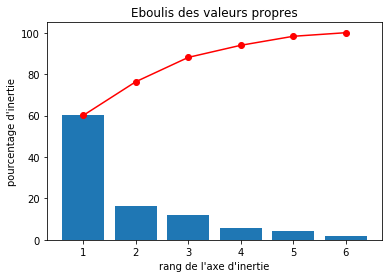

[60.1 16.2 11.8  5.8  4.4  1.7]


In [34]:
#Affichage des éboulis des valeurs propres
display_scree_plot(pca)
print(np.around(prop_var, 1))

In [35]:
#Racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#Corrélation des variables avec les axes
covar = np.zeros((p,p))
for k in range(p):
    covar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

mat_cor = pd.DataFrame(np.around(covar, 2),
                       index=features,
                       columns=['COR_'+str(i + 1) for i in range(p)])
mat_cor

,COR_1,COR_2,COR_3,COR_4,COR_5,COR_6
Evol pop,-0.44,0.87,-0.06,-0.12,0.18,-0.03
Ratio prot Ani,0.87,-0.11,-0.19,0.22,0.36,-0.09
Disp alim prot Tot,0.89,0.10,0.34,-0.10,0.11,0.23
Disp alim Kcal Tot,0.85,0.09,0.42,-0.21,-0.09,-0.20
PIB/Hab,0.78,0.44,-0.12,0.34,-0.27,0.02
Ind Stab Pol,0.72,-0.03,-0.60,-0.34,-0.08,0.02


In [36]:
#Qualité de représentation des variables - cos2
cos2var = covar**2
    
qual_repr_var = pd.DataFrame(np.around(cos2var, 2),
                             index=features,
                             columns=['COS_2_' + str(i + 1) for i in range(p)])
qual_repr_var

,COS_2_1,COS_2_2,COS_2_3,COS_2_4,COS_2_5,COS_2_6
Evol pop,0.20,0.75,0.00,0.01,0.03,0.00
Ratio prot Ani,0.76,0.01,0.04,0.05,0.13,0.01
Disp alim prot Tot,0.80,0.01,0.11,0.01,0.01,0.05
Disp alim Kcal Tot,0.72,0.01,0.18,0.05,0.01,0.04
PIB/Hab,0.60,0.19,0.01,0.12,0.07,0.00
Ind Stab Pol,0.52,0.00,0.36,0.11,0.01,0.00


In [37]:
#Vérification
np.sum(qual_repr_var, axis=1)

Evol pop              0.99
Ratio prot Ani        1.00
Disp alim prot Tot    0.99
Disp alim Kcal Tot    1.01
PIB/Hab               0.99
Ind Stab Pol          1.00
dtype: float64

In [38]:
#Contribution des variables aux axes
ctrvar = cos2var * 100
for j in range(p):
    ctrvar[:,j] = ctrvar[:,j]/eigval[j]

ctr_ax_var = pd.DataFrame(np.around(ctrvar,1),
                          index=features,
                          columns=['CTR_' + str(i + 1) for i in range(p)])

ctr_ax_var

,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6
Evol pop,5.4,77.4,0.5,4.2,11.7,0.7
Ratio prot Ani,21.2,1.2,5.0,14.2,50.2,8.2
Disp alim prot Tot,22.1,1.0,16.3,2.9,4.9,52.8
Disp alim Kcal Tot,20.0,0.8,25.4,13.1,3.0,37.7
PIB/Hab,16.8,19.5,2.0,33.5,27.9,0.3
Ind Stab Pol,14.5,0.1,50.7,32.1,2.2,0.4


In [39]:
#Vérification
np.sum(ctr_ax_var, axis=0)

CTR_1    100.0
CTR_2    100.0
CTR_3     99.9
CTR_4    100.0
CTR_5     99.9
CTR_6    100.1
dtype: float64

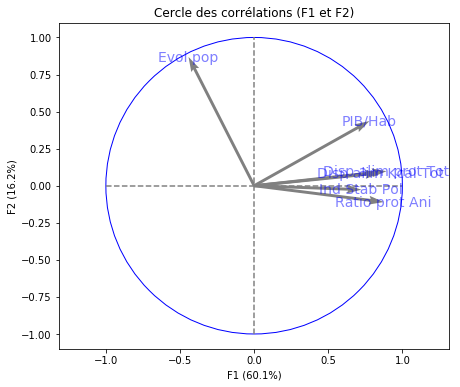

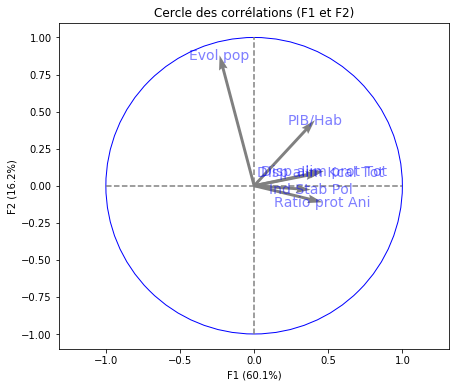

array([[-0.23298457,  0.46016583,  0.47040936,  0.44697988,  0.40961538,
         0.38092631],
       [ 0.87982225, -0.11154496,  0.09915809,  0.08719347,  0.44192849,
        -0.02710537],
       [-0.0740752 , -0.22373835,  0.40364344,  0.50439625, -0.14274588,
        -0.71185253],
       [-0.20531552,  0.37626173, -0.17084497, -0.36220987,  0.57878042,
        -0.56648202],
       [ 0.34268666,  0.70866548,  0.22174388, -0.17303112, -0.52814919,
        -0.14935663],
       [-0.08096445, -0.28629815,  0.72635826, -0.614048  ,  0.05108542,
         0.06493949]])

In [40]:
#Contribution des variables aux composantes principales
pcs = pca.components_


display_circles(covar.T, n_comp, pca,
                [(0,1)],# (2,3), (4,5)],
                labels = dispo_alim5.columns)

display_circles(pcs, n_comp, pca,
                [(0,1)],# (2,3), (4,5)],
                labels = dispo_alim5.columns)
pcs

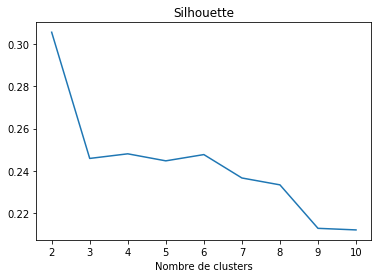

In [41]:
#faire varier le nombre de clusters de 2 à 10 #utilisation de lamétrique "silhouette"
res = np.arange(9,dtype='float')
for k in np.arange(9):
    Z = linkage(X_scaled, 'ward')
    clusterh = fcluster(Z, k+2, criterion='maxclust') # fromage_std est la table de donnée centrée-reduite
    res[k] = metrics.silhouette_score(X_scaled,clusterh)

#graphique
plt.title("Silhouette")
plt.xlabel("Nombre de clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()
plt.cla()
plt.clf()
plt.close()

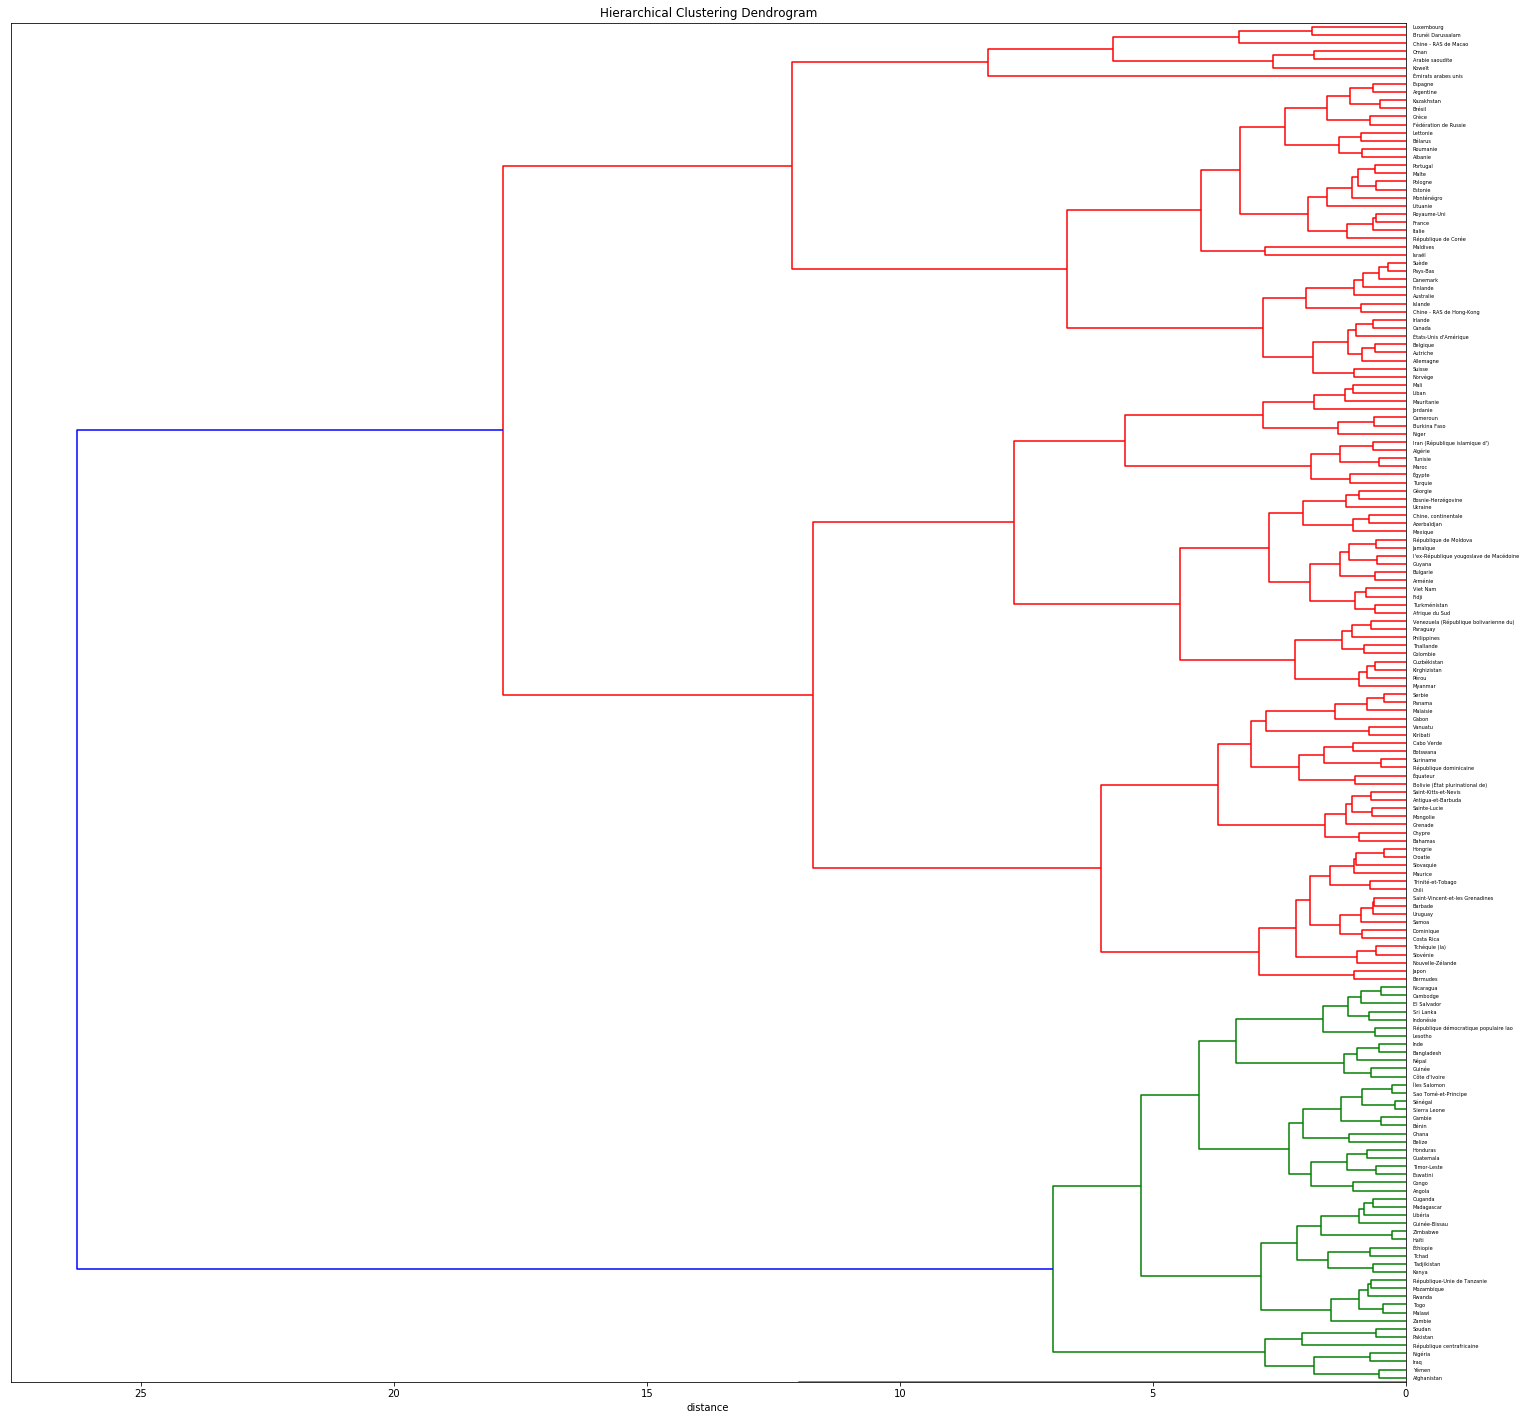

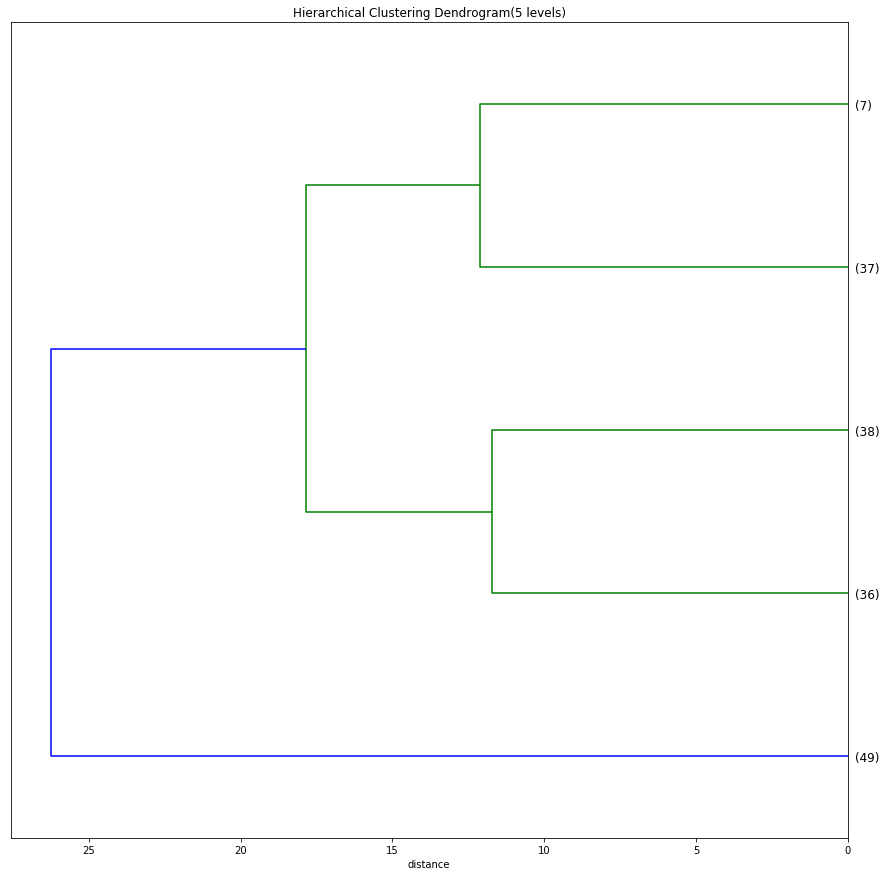

In [42]:
#Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

#Affichage du dendrogramme
plt.figure(figsize=(25,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
hierarchy.dendrogram(Z, labels = pays, orientation = "left")
plt.plot([-12,12], [0,0])
plt.savefig(f'graph/dend.png', dpi=150)

#Affichage du dendrogramme avec 5 groupes
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram(5 levels)')
plt.xlabel('distance')
hierarchy.dendrogram(Z, labels = pays, orientation = "left", p=5, truncate_mode='lastp')
plt.savefig(f'graph/dend2.png')
plt.show()

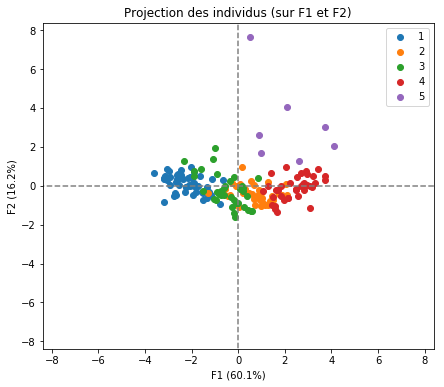

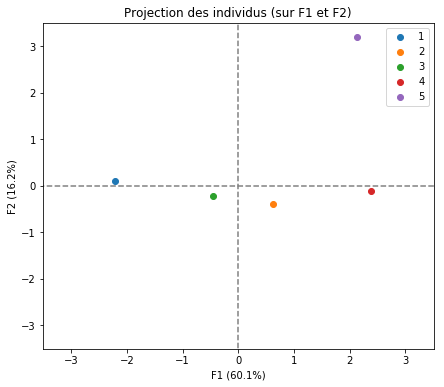

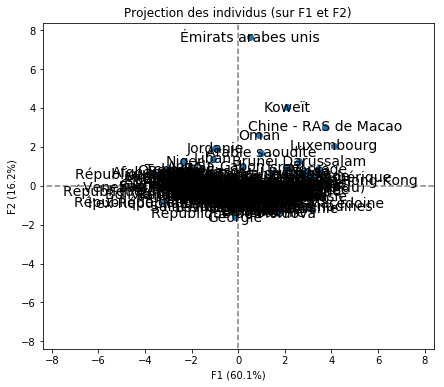

In [43]:
#Coupage du dendrogramme en 5 clusters
cluster = fcluster(Z, 5, criterion='maxclust')

#Création du dataframe d'appartenance des pays à chaque cluster
clusterdf = pd.DataFrame({'Pays':pays, 'Cluster':cluster})

#Ajout de la colonne cluster au dataframe principal
clusterdf.set_index('Pays', inplace=True)
dispo_alim7a = pd.merge(dispo_alim5a, clusterdf, on = 'Pays')
dispo_alim7 = pd.merge(dispo_alim5, clusterdf, on = 'Pays')
dispo_alim8c = dispo_alim7.groupby('Cluster').mean()

#Sauvegarde de la table des pays avec leurs clusters
dispo_alim7a.to_csv('created_csv/table_pays_clusters.csv')

#Calcul des centroides
XC = dispo_alim8c.values

#Centrage et réduction
XC_scaled = std_scale.transform(XC)
len(XC), len(XC_scaled)

#Calcul des coordonnées des individus sur le premier plan factoriel
X_projected = pca.transform(X_scaled)

#Calcul des coordonnées des centroides sur le premier plan factoriel
XC_projected = pca.transform(XC_scaled)

display_factorial_planes(X_projected,
                         n_comp,
                         pca,
                         [(0,1)],
                         labels=None,
                         alpha=1,
                         illustrative_var=clusterdf.Cluster)

#Projection des Centroides
display_factorial_planes_centroid(XC_projected,
                         n_comp,
                         pca,
                         [(0,1)],
                         labels=None,
                         alpha=1,
                         illustrative_var=dispo_alim8c.index)

display_factorial_planes(X_projected,
                         n_comp,
                         pca,
                         [(0,1)],
                         labels=pays,
                         alpha=1)


In [44]:
#Calcul des coordonnées des centroides
coord_centroid = pd.DataFrame(np.around(XC_projected, 2),
                              index=dispo_alim8c.index,
                              columns=['Coord_F' + str(i + 1) for i in range(p)])

#Sauvegarde de la table des centroides avec leurs coordonnées dans chaque dimension
coord_centroid.to_csv('created_csv/coord_centroid.csv')
coord_centroid

,Coord_F1,Coord_F2,Coord_F3,Coord_F4,Coord_F5,Coord_F6
Cluster,,,,,,
1,-2.21,0.10,-0.17,0.02,-0.18,0.04
2,0.62,-0.40,-0.83,-0.04,0.23,-0.10
3,-0.45,-0.23,0.75,-0.04,0.04,-0.02
4,2.38,-0.11,0.34,-0.07,0.07,0.06
5,2.13,3.19,-0.45,0.68,-0.53,-0.03


In [45]:
#Liste principale des pays potentiels
dispo_alim8 = dispo_alim7a[dispo_alim7a['Cluster'] == 5]
selection = dispo_alim8.index
dispo_alim8

,2013,Evol pop,Ratio prot Ani,Disp alim prot Tot,Disp alim Kcal Tot,PIB/Hab,Ind Stab Pol,Cluster
Pays,,,,,,,,
Arabie saoudite,29944.476,32.75,43.577431,91.63,3255.0,49537.6,-0.43,5
Brunéi Darussalam,405.716,14.81,56.685580,93.41,2985.0,79070.2,1.07,5
Chine - RAS de Macao,575.841,25.14,64.424294,94.84,2915.0,135319.0,0.76,5
Koweït,3598.385,65.89,49.501109,108.24,3501.0,74084.5,0.17,5
Luxembourg,544.721,21.77,63.329821,113.88,3539.0,90656.4,1.34,5
Oman,3711.481,55.60,51.773371,88.25,3143.0,41924.8,0.46,5
Émirats arabes unis,9006.263,140.68,39.858536,104.62,3280.0,61688.4,0.89,5


In [46]:
#Contribution des individus dans l'inertie total
di = np.sum(X_scaled**2, axis=1)
ctr_tot = pd.DataFrame({'ID':pays, 'd_i': np.around(di, 2)})

ctr_tot.describe()

,d_i
count,167.000000
mean,5.999880
std,6.441709
min,0.290000
25%,2.715000
50%,4.630000
75%,8.015000
max,61.830000


In [47]:
#Contribution des individus de la selection 1 dans l'inertie total
ctr_tot['Selection'] = ctr_tot['ID'].isin(selection)
ctr_tot[ctr_tot['Selection'] == True].sort_values(by='d_i').head()

,ID,d_i,Selection
7,Arabie saoudite,4.86,True
107,Oman,8.01,True
22,Brunéi Darussalam,12.81,True
80,Koweït,21.13,True
86,Luxembourg,23.39,True


In [48]:
#Qualité de représentation des individus
cos2 = X_projected**2
for j in range(p):
    cos2[:,j] = 100 * cos2[:,j]/di

qual_repr = pd.DataFrame(np.around(cos2, 1),
                         index=pays,
                         columns=['COS2_' + str(i + 1) for i in range(p)])

qual_repr = qual_repr.reset_index()

qual_repr.head()

,Pays,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6
0,Afghanistan,83.1,2.9,4.9,7.7,0.7,0.6
1,Afrique du Sud,12.3,22.8,32.0,29.8,0.5,2.6
2,Albanie,47.2,28.0,14.8,2.1,2.7,5.1
3,Algérie,3.0,1.8,88.6,2.1,4.3,0.1
4,Allemagne,95.9,0.7,0.0,0.0,2.4,0.9


In [49]:
#Qualité de représentation des individus de la selection 1
qual_repr['Selection'] = qual_repr['Pays'].isin(selection)
qual_repr[qual_repr['Selection'] == True]

,Pays,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6,Selection
7,Arabie saoudite,19.4,59.3,8.2,6.9,5.1,1.1,True
22,Brunéi Darussalam,53.0,12.5,9.9,12.7,11.4,0.5,True
34,Chine - RAS de Macao,34.1,22.8,5.6,26.2,10.9,0.3,True
80,Koweït,20.8,77.6,0.7,0.5,0.3,0.1,True
86,Luxembourg,72.1,18.0,1.0,3.4,5.4,0.1,True
107,Oman,10.2,83.3,2.1,0.3,2.0,2.1,True
162,Émirats arabes unis,0.4,93.9,0.6,3.1,2.0,0.0,True


In [50]:
#Vérification des cos
np.sum(cos2, axis=1)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 10

In [51]:
#Contribution des individus aux axes
ctr = X_projected**2
for j in range(p):
    ctr[:,j] = 100 * ctr[:,j]/(n*eigval[j])

ctr_ax = pd.DataFrame(np.around(ctr, 2),
                     index=pays,
                     columns=['CTR_' + str(i + 1) for i in range(p)])

ctr_ax = ctr_ax.reset_index()

ctr_ax.describe()

,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.598743,0.599162,0.598922,0.598743,0.598563,0.598802
std,0.608127,2.904633,0.906260,1.584977,1.213256,0.908729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.085000,0.030000,0.085000,0.050000,0.070000,0.060000
50%,0.390000,0.140000,0.260000,0.190000,0.270000,0.220000
75%,1.000000,0.350000,0.755000,0.490000,0.670000,0.715000
max,2.800000,35.660000,6.220000,18.130000,10.190000,6.930000


In [52]:
#Contribution des individus de la selection 1 aux axes
ctr_ax['Selection'] = ctr_ax['Pays'].isin(selection)
ctr_ax[ctr_ax['Selection'] == True]

,Pays,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6,Selection
7,Arabie saoudite,0.16,1.77,0.34,0.57,0.57,0.31,True
22,Brunéi Darussalam,1.13,0.98,1.08,2.78,3.34,0.36,True
34,Chine - RAS de Macao,2.29,5.67,1.93,18.13,10.14,0.67,True
80,Koweït,0.73,10.07,0.12,0.20,0.15,0.10,True
86,Luxembourg,2.80,2.58,0.21,1.37,2.91,0.07,True
107,Oman,0.14,4.10,0.14,0.04,0.36,0.96,True
162,Émirats arabes unis,0.04,35.66,0.31,3.31,2.78,0.08,True


In [53]:
#Vérification du calcul de la contribution aux axes
np.sum(ctr_ax,axis=0)

Pays         AfghanistanAfrique du SudAlbanieAlgérieAllemag...
CTR_1                                                    99.99
CTR_2                                                   100.06
CTR_3                                                   100.02
CTR_4                                                    99.99
CTR_5                                                    99.96
CTR_6                                                      100
Selection                                                    7
dtype: object

<a id='test'></a>
<h3 style='color:#8677b2'>Tests statistiques</h3>

[Haut de page](#sommaire)

* Test d'adéquation à une loi Normale

In [54]:
n = len(dispo_alim5a)
dispo_alim5a.columns, n

(Index([                2013,           'Evol pop',     'Ratio prot Ani',
        'Disp alim prot Tot', 'Disp alim Kcal Tot',            'PIB/Hab',
              'Ind Stab Pol'],
       dtype='object'), 167)

* La variable "Ind Stab Pol" (indice de stabilité politique)

In [55]:
#Calcul des indicateurs centraux et de dispersion
x1 = dispo_alim5a['Ind Stab Pol']
x1bar = np.mean(x1)
x1sprime = np.std(x1)
x1sprime2 = np.var(x1, ddof=1)
x1bar, x1sprime, x1sprime2, x1.min(), x1.max()

(-0.06664670658682635, 0.9202977979221785, 0.8520501334680037, -2.6, 1.45)

Text(0.5, 1.0, 'Distribution marginale de la variable Ind Stab Pol')

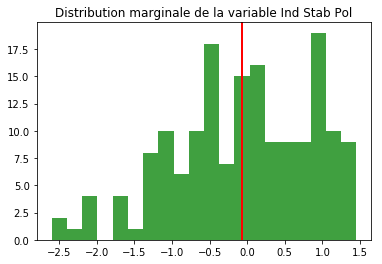

In [56]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x1, 20, density=False, facecolor='g', alpha=0.75)
plt.axvline(x1bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[6]}')

In [57]:
#Test de Kolmogorov-Smirnov
ks_2samp(x1,list(np.random.normal(x1bar, x1sprime, 1000)))

Ks_2sampResult(statistic=0.08147305389221549, pvalue=0.28626034706723574)

In [58]:
#Test de Shapiro
stats.shapiro(x1)

(0.9681621789932251, 0.0006971274851821363)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse "H0: l'indice de stabilité politique suit une loi normale" aux niveaux de test usuels<br/>
</p>

* La variable "Evol pop" (évolution de la population entre 2003 et 2013)

In [59]:
#Calcul des indicateurs centraux et de dispersion
x2 = dispo_alim5a['Evol pop']
x2bar = np.mean(x2)
x2sprime = np.std(x2)
x2sprime2 = np.var(x2, ddof=1)
x2bar, x2sprime, x2sprime2, x2.min(), x2.max()

(16.59910179640719, 17.001017328712845, 290.7757624413823, -12.21, 140.68)

Text(0.5, 1.0, 'Distribution marginale de la variable Evol pop')

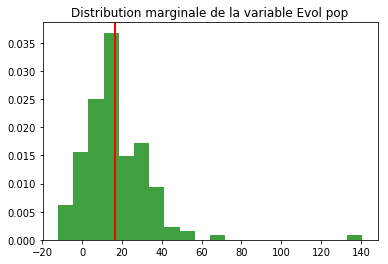

In [60]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x2, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x2bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[1]}')

In [61]:
#Test de Kolmogorov-Smirnov
ks_2samp(x2,list(np.random.normal(x2bar, x2sprime, 1000)))

Ks_2sampResult(statistic=0.11065868263473044, pvalue=0.05570698122666316)

In [62]:
#Test de Shapiro
stats.shapiro(x2)

(0.8398498296737671, 3.02080300877694e-12)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse "H0: l'évolution de la population suit une loi normale"  aux niveaux de test usuels<br/>
</p>

* La variable "Ratio prot Ani" (Proportion de protéines animales par rapport aux protéines totales)

In [63]:
#Calcul des indicateurs centraux et de dispersion
x3 = dispo_alim5a['Ratio prot Ani']
x3bar = np.mean(x3)
x3sprime = np.std(x3)
x3sprime2 = np.var(x3, ddof=1)
x3bar, x3sprime, x3sprime2, x3.min(), x3.max()

(42.82183474662434,
 16.04913412496952,
 259.1263610176543,
 9.839816933638444,
 73.08406874129122)

Text(0.5, 1.0, 'Distribution marginale de la variable Ratio prot Ani')

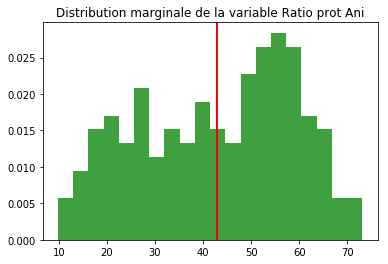

In [64]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x3, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x3bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[2]}')

In [65]:
#Test de Kolmogorov-Smirnov
ks_2samp(x3,list(np.random.normal(x3bar, x3sprime, 1000)))

Ks_2sampResult(statistic=0.10220958083832332, pvalue=0.09425010231492414)

In [66]:
#Test de Shapiro
stats.shapiro(x3)

(0.9587015509605408, 7.563964027212933e-05)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse "H0: le ratio prot Ani suit une loi normale" aux niveaux de test de usuels<br/>
</p>

* La variable "Disp alim prot Tot" (disponnibilité totale en prtéines)

In [67]:
#Calcul des indicateurs centraux et de dispersion
x4 = dispo_alim5a['Disp alim prot Tot']
x4bar = np.mean(x4)
x4sprime = np.std(x4)
x4sprime2 = np.var(x4, ddof=1)
x4bar, x4sprime, x4sprime2, x4.min(), x4.max()

(81.52526946107787, 20.05916395217719, 404.79397447514606, 37.66, 133.54)

Text(0.5, 1.0, 'Distribution marginale de la variable Disp alim prot Tot')

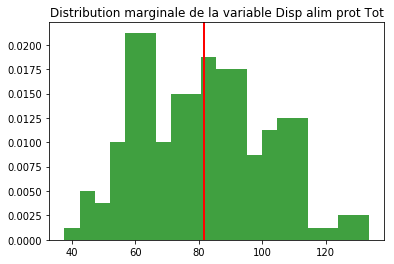

In [68]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x4, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x4bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[3]}')

In [69]:
#Test de Kolmogorov-Smirnov
ks_2samp(x4,list(np.random.normal(x4bar, x4sprime, 1000)))

Ks_2sampResult(statistic=0.0834011976047904, pvalue=0.26103721682642156)

In [70]:
#Test de Shapiro
stats.shapiro(x4)

(0.9817796349525452, 0.027209850028157234)

<p style='color:#8677b2;text-align:center'>
    On accepte l'hypothèse "H0: la diso alim prot tot suit une loi normale" au niveau de test alpha = 2.5%<br/>
</p>

* La variable "Disp alim Kcal Tot" (disponnibilité calorique totale)

In [71]:
#Calcul des indicateurs centraux et de dispersion
x5 = dispo_alim5a['Disp alim Kcal Tot']
x5bar = np.mean(x5)
x5sprime = np.std(x5)
x5sprime2 = np.var(x5, ddof=1)
x5bar, x5sprime, x5sprime2, x5.min(), x5.max()

(2854.2335329341317, 436.1864259201327, 191404.7342904552, 1879.0, 3768.0)

Text(0.5, 1.0, 'Distribution marginale de la variable Disp alim Kcal Tot')

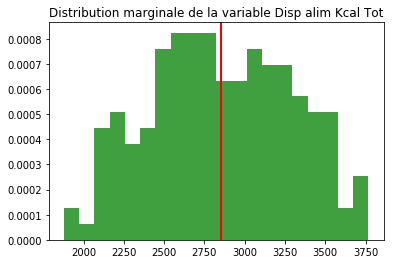

In [72]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x5, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x5bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[4]}')

In [73]:
#Test de Kolmogorov-Smirnov
ks_2samp(x5,list(np.random.normal(x5bar, x5sprime, 1000)))

Ks_2sampResult(statistic=0.03955688622754491, pvalue=0.9761520815341682)

In [74]:
#Test de Shapiro
stats.shapiro(x5)

(0.9826980829238892, 0.03549310937523842)

<p style='color:#8677b2;text-align:center'>
    On accepte l'hypothèse "H0: la disp alim Kcal Tot suit une loi normale" si alpha = 3.5%<br/>
</p>

* La variable "PIB/Hab"

In [75]:
#Calcul des indicateurs centraux et de dispersion
x6 = dispo_alim5a['PIB/Hab']
x6bar = np.mean(x6)
x6sprime = np.std(x6)
x6sprime2 = np.var(x6, ddof=1)
x6bar, x6sprime, x6sprime2, x6.min(), x6.max()

(17849.81976047905, 19279.387834795478, 373933920.55725783, 593.1, 135319.0)

Text(0.5, 1.0, 'Distribution marginale de la variable Ind Stab Pol')

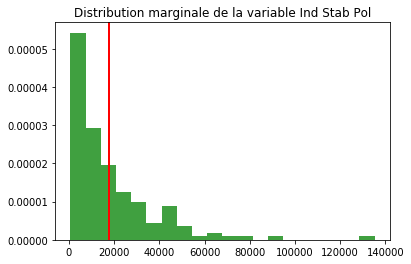

In [76]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x6, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x6bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[6]}')

In [77]:
#Test de Kolmogorov-Smirnov
ks_2samp(x6,list(np.random.normal(x6bar, x6sprime, 1000)))

Ks_2sampResult(statistic=0.168, pvalue=0.0005208251602832936)

In [78]:
#Test de Shapiro
stats.shapiro(x6)

(0.7742094993591309, 9.171036631126176e-15)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse "H0: la PIB/Hab suit une loi normale" aux niveaux de test usuels<br/>
</p>

* La variable population en "2013" (indice de valeur des importations)

In [79]:
#Calcul des indicateurs centraux et de dispersion
x8 = dispo_alim5a[2013]
x8bar = np.mean(x8)
x8sprime = np.std(x8)
x8sprime2 = np.var(x8, ddof=1)
x8bar, x8sprime, x8sprime2, x8.min(), x8.max()

(41810.2915748503,
 149192.1740285049,
 22392390964.79357,
 53.169,
 1382793.2119999998)

Text(0.5, 1.0, 'Distribution marginale de la variable 2013')

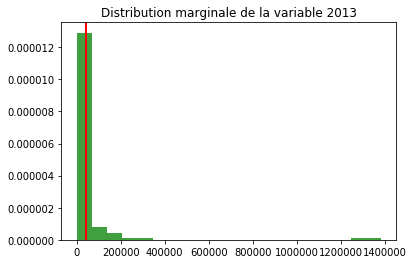

In [80]:
#Représentation de la distribution marginale
n, bins, patches = plt.hist(x8, 20, density=True, facecolor='g', alpha=0.75)
plt.axvline(x8bar, color='r', linewidth=2)
plt.title(f'Distribution marginale de la variable {dispo_alim5a.columns[0]}')

In [81]:
#Test de Kolmogorov-Smirnov
ks_2samp(x8,list(np.random.normal(x8bar, x8sprime, 1000)))

Ks_2sampResult(statistic=0.365, pvalue=2.4097613774465332e-17)

In [82]:
#Test de Shapiro
stats.shapiro(x8)

(0.2396169900894165, 9.059284798533922e-26)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse "H0: la population en 2013 suit une loi normale" aux niveaux de test usuels<br/>
</p>

* Test de comparaison de deux population Gaussienne

In [83]:
#Création des tables des clusters (les plus nombreux) à tester
dispo_alim9 = dispo_alim7[dispo_alim7['Cluster'] == 1]
dispo_alim10 = dispo_alim7[dispo_alim7['Cluster'] == 4]

In [84]:
#Variable des échantillons à tester
ech1 = dispo_alim9['Disp alim Kcal Tot']
ech2 = dispo_alim10['Disp alim Kcal Tot']

In [85]:
#Calcul de la moyenne et de la variance de l'échantillon 1
ech1xbar = np.mean(ech1)
ech1sprime2 = np.var(ech1, ddof=1)
ech1xbar, ech1sprime2

(2387.9795918367345, 58263.520408163284)

In [86]:
#Calcul de la moyenne et de la variance de l'échantillon 2
ech2xbar = np.mean(ech2)
ech2sprime2 = np.var(ech2, ddof=1)
ech2xbar, ech2sprime2

(3379.2972972972975, 35967.82582582582)

In [87]:
#Test de Bartlett (égalité des variances)
scipy.stats.bartlett(ech1, ech2)

BartlettResult(statistic=2.289853239596829, pvalue=0.1302222358565867)

<p style='color:#8677b2;text-align:center'>
    On accepte l'hypothèse H0 d'égalité des variance aux niveaux de test usuels<br/>
</p>

In [88]:
#Test de Student (égalité des moyenne)
scipy.stats.ttest_ind(ech1, ech2, equal_var=True)

Ttest_indResult(statistic=-20.623453782545823, pvalue=1.2662723670678648e-34)

<p style='color:#8677b2;text-align:center'>
    On rejette l'hypothèse H0 d'égalité des moyennes aux niveaux de test usuels<br/>
</p>

[Haut de page](#sommaire)